In [1]:
%matplotlib inline

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow.keras as keras
from tensorflow.keras import layers
# from tensorflow.keras import ops
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

from graph_visualization import GraphVisualization

print("Tensorflow verions:", tf.__version__)
print('Available GPUs:', tf.config.experimental.list_physical_devices('GPU'))

Tensorflow verions: 2.4.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [3]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 10  # Max sequence size
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "gpt-dataset/custom-2"
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

# filenames = filenames[:1000]

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]

    # zeros_column = tf.zeros_like(y[:, :1])  # Create a column of zeros with the same shape as the first column of y
    # y = tf.concat([zeros_column, y], axis=1)  # Concatenate the zeros column with y along the column axis
    
    print('x',x)
    print('y',y)
    return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

22 files
x Tensor("strided_slice:0", shape=(None, 10), dtype=int64)
y Tensor("strided_slice_1:0", shape=(None, 10), dtype=int64)


In [4]:
list(text_ds.take(1))[0][1]

<tf.Tensor: shape=(22, 10), dtype=int64, numpy=
array([[ 2, 17,  6,  7,  4,  9,  5,  0,  0,  0],
       [ 2, 17,  2, 10,  4,  8,  5,  0,  0,  0],
       [ 2, 16,  2, 10,  4,  8,  5,  0,  0,  0],
       [ 2, 18,  2, 10,  4,  9,  5,  0,  0,  0],
       [ 2, 12,  6,  7,  4,  9,  5,  0,  0,  0],
       [ 2, 15,  6,  7,  4,  8,  5,  0,  0,  0],
       [ 2, 13,  6,  7,  4,  8,  5,  0,  0,  0],
       [ 2, 13,  2, 10,  4,  9,  5,  0,  0,  0],
       [ 2, 11,  2, 10,  4,  8,  5,  0,  0,  0],
       [ 2, 14,  6,  7,  4,  9,  5,  0,  0,  0],
       [ 6, 22,  6,  7,  4,  9,  5,  0,  0,  0],
       [ 2, 11,  6,  7,  4,  9,  5,  0,  0,  0],
       [ 2, 15,  2, 10,  4,  9,  5,  0,  0,  0],
       [ 2, 14,  6,  7,  4,  8,  5,  0,  0,  0],
       [ 2, 12,  2, 10,  4,  8,  5,  0,  0,  0],
       [ 2, 20,  2, 10,  4,  9,  5,  0,  0,  0],
       [ 2, 19,  2, 10,  4,  9,  5,  0,  0,  0],
       [ 2, 18,  6,  7,  4,  8,  5,  0,  0,  0],
       [ 2, 19,  6,  7,  4,  8,  5,  0,  0,  0],
       [ 2, 20,  6,  

In [5]:
graph_embedding_size = 10

def node2vec(G):
        walk_length = 100
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=G.nodes(),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False,  # for weighted random walks
            seed=42,  # random seed fixed for reproducibility
        )

        model = Word2Vec(
            walks,  vector_size=graph_embedding_size, window=5, min_count=0, sg=1, workers=1
        )

        return pd.DataFrame([(key, vector) for key,vector in zip(model.wv.index_to_key, model.wv.vectors)], columns=['node', 'embedding'])

    
def get_graph():
    nodes, edges, edge_types = [], [], []

    nodes.append('vehicle')
    nodes.append('animal')
    nodes.append('car')
    nodes.append('truck')
    nodes.append('airplane')
    nodes.append('motorcycle')
    nodes.append('bus')
    nodes.append('bird')
    nodes.append('cat')
    nodes.append('lion')
    nodes.append('bear')
    nodes.append('boar')
    nodes.append('crane')
    nodes.append('yes')
    nodes.append('no')

    edges.append({'source': 'car', 'target': 'vehicle'})
    edges.append({'source': 'truck', 'target': 'vehicle'})
    edges.append({'source': 'airplane', 'target': 'vehicle'})
    edges.append({'source': 'motorcycle', 'target': 'vehicle'})
    edges.append({'source': 'bus', 'target': 'vehicle'})
    edges.append({'source': 'bird', 'target': 'animal'})
    edges.append({'source': 'cat', 'target': 'animal'})
    edges.append({'source': 'lion', 'target': 'animal'})
    edges.append({'source': 'bear', 'target': 'animal'})
    edges.append({'source': 'boar', 'target': 'animal'})
    edges.append({'source': 'crane', 'target': 'animal'})

    for i in range(10):
        edge_types.append('is-a')
    
    return {'nodes':nodes, 'edges': edges, 'edge_types': edge_types}

def get_embeddings(graph):
    edges_ = pd.DataFrame({
            'source': [e['source'] for e in graph['edges']],
            'target': [e['target'] for e in graph['edges']]
        })
    
    G = StellarGraph(IndexedArray(index=graph['nodes']), edges_)

    node_embeddings = node2vec(G)
        
    return node_embeddings
    
graph = get_graph()
node_embeddings = get_embeddings(graph)

# node_embeddings = []
# node_embeddings.append([1,0])
# node_embeddings.append([0,1])
# node_embeddings.append([1,0])
# node_embeddings.append([1,0])
# node_embeddings.append([1,0])
# node_embeddings.append([1,0])
# node_embeddings.append([1,0])
# node_embeddings.append([0,1])
# node_embeddings.append([0,1])
# node_embeddings.append([0,1])
# node_embeddings.append([0,1])
# node_embeddings.append([0,1])

# graph_embedding_size = 1
# node_embeddings = []
# node_embeddings.append([1])
# node_embeddings.append([0])
# node_embeddings.append([1])
# node_embeddings.append([1])
# node_embeddings.append([1])
# node_embeddings.append([1])
# node_embeddings.append([1])
# node_embeddings.append([0])
# node_embeddings.append([0])
# node_embeddings.append([0])
# node_embeddings.append([0])
# node_embeddings.append([0])
# node_embeddings.append([0])
# node_embeddings.append([2])
# node_embeddings.append([3])

# node_embeddings = pd.DataFrame({'node': graph['nodes'], 'embedding': node_embeddings})

tmp = []
for i,word in enumerate(vocab):
    lower_nodes = list(map(lambda k: k.lower(), node_embeddings['node']))
    index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
    if index != -1:
        tmp.append(node_embeddings.iloc[index][1])
    else:
        tmp.append(np.ones(graph_embedding_size) * -10)

# for row in node_embeddings.iterrows():
#     if row[0] not in vocab:
#         tmp.append(row[1])

node_embeddings = np.array(tmp).tolist()

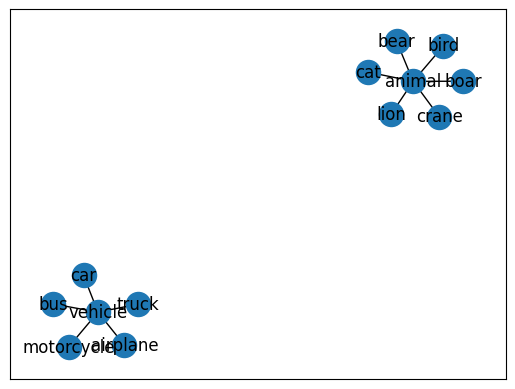

In [6]:
vis = GraphVisualization()
for edge in graph['edges']:
    vis.addEdge(edge['source'], edge['target'])
vis.visualize()

In [7]:
[(word, emb) for word, emb in zip(vocab, node_embeddings)]

[('', [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('[UNK]',
  [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('a', [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('is',
  [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('?', [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('.', [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('an',
  [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]),
 ('animal',
  [-0.4163645803928375,
   0.25741854310035706,
   0.6086070537567139,
   -0.1655154526233673,
   0.49575382471084595,
   -0.0455486997961998,
   0.8012338876724243,
   1.535124659538269,
   -1.2733432054519653,
   0.15829606354236603]),
 ('yes',
  [0.07898068428039551,
   -0.06989505141973495,
   -0.09155865013599396,
   -0.003557539079338312,
   -0.03099841997027397,
   0.0789431557059288,
   0.05938572809100151

In [8]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # Modified line
        positions = tf.range(0, maxlen, 1)  # Modified line
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
class NodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, node_embeddings):
        super().__init__()
        self.node_embeddings = tf.constant(node_embeddings, dtype=tf.float32)
        self.node_embed_dim = node_embed_dim
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
         # Reshape x to add a new dimension for embedding
        node_indices = tf.cast(tf.math.round(x), tf.int32)
        node_emb = tf.gather(self.node_embeddings, node_indices)
        node_emb = self.dense(node_emb)  # Apply dense layer to each token embedding
        return node_emb

In [14]:
class TextGenerator(tf.keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, model = None, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        if model: self.model = model
        self.yes_count = 0
        self.no_count = 0
        self.activation_outputs = []
        self.gradients = []

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = tf.convert_to_tensor(indices, dtype=tf.int32)
        preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = tf.convert_to_tensor(preds, dtype=tf.float32)
  
        # Reshape logits to a matrix
        logits_matrix = tf.reshape(logits, (1, -1))
   
        # Sample from the softmax probabilities
        sampled_index = tf.random.categorical(tf.math.log(preds)[tf.newaxis, :], num_samples=1)

        # Return the sampled index
        return indices[sampled_index[0, 0]]

    def detokenize(self, number):
        return self.index_to_word[number] if number < len(self.index_to_word) else '---'

    def generate_token(self, _start_tokens, tokens_generated):
        pad_len = maxlen - len(_start_tokens)
        sample_index = len(_start_tokens) - 1
        if pad_len < 0:
            x = _start_tokens[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            x = _start_tokens + [0] * pad_len
        else:
            x = _start_tokens
        x = np.array([x])
        y = self.model.predict(x, verbose=0)
        sample_token = self.sample_from(y[0][sample_index])
        tokens_generated.append(sample_token)
        _start_tokens.append(sample_token)
        num_tokens_generated = len(tokens_generated)

        return _start_tokens, tokens_generated, num_tokens_generated, y

    def get_generated_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in tokens_generated])
        
    def get_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        
    def on_epoch_end(self, epoch, logs=None):
        _start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        raw_outputs = []
        while num_tokens_generated <= self.max_tokens:
            _start_tokens, tokens_generated, num_tokens_generated, raw_output = self.generate_token(_start_tokens, tokens_generated)
            raw_outputs.append(raw_output)
            
        txt = self.get_text(tokens_generated)
        print(f"generated text:\n{txt}\n")

        self.yes_count += 1 if 'yes' in txt else 0
        self.no_count += 1 if 'no' in txt else 0

        return txt, raw_outputs
    
    def generate(self):
        return self.on_epoc_end(1)

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

def callback(start_prompt, model=None, top_k=10):
    start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
    num_tokens_generated = 10
    return TextGenerator(num_tokens_generated, start_tokens, vocab, top_k=top_k) if not model else TextGenerator(num_tokens_generated, start_tokens, vocab, model, top_k)

In [15]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="float32")
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)

    outputs_1 = layers.Dense(vocab_size, name='text_output')(x)

    node_embedding_layer = NodeEmbedding(embed_dim, node_embeddings)
    x2 = node_embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x2 = transformer_block(x2)

    outputs_2 = layers.Dense(vocab_size, name='graph_output')(x2)

    # Concatenate outputs of both branches
    outputs = layers.Average()([outputs_1, outputs_2])

    # outputs = outputs_2

    # Softmax layer
    # softmax_output = layers.Softmax()(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer='adam',
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [16]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 10, 128)      5120        input_1[0][0]                    
__________________________________________________________________________________________________
node_embedding (NodeEmbedding)  (None, 10, 128)      1408        input_1[0][0]                    
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 10, 128)      165504      token_and_position_embedding[0][0
______________________________________________________________________________________________

In [17]:
text_gen_callback = callback("is a bus a vehicle ?", model, top_k=1)

In [18]:
history = model.fit(text_ds, verbose=1, epochs=200, callbacks=[text_gen_callback])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 3.7888
generated text:
is a bus a vehicle ? . .  .       

Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 2.4417
generated text:
is a bus a vehicle ?  .         

Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 1.8184
generated text:
is a bus a vehicle ?           

Epoch 4/200
1/1 [==============================] - 0s 29ms/step - loss: 1.4812
generated text:
is a bus a vehicle ?           

Epoch 5/200
1/1 [==============================] - 0s 32ms/step - loss: 1.2423
generated text:
is a bus a vehicle ?           

Epoch 6/200
1/1 [==============================] - 0s 33ms/step - loss: 1.0312
generated text:
is a bus a vehicle ? no .         

Epoch 7/200
1/1 [==============================] - 0s 28ms/step - loss: 0.9072
generated text:
is a bus a vehicle ? no .         

Epoch 8/200
1/1 [==============================] - 0s 29ms/step - loss: 0.8189
generated text:
i

In [707]:
text_gen_callback.yes_count, text_gen_callback.no_count

(334, 127)

In [823]:
generator = callback('is a crane a vehicle ?', model, 1)
output = generator.on_epoch_end(0)

generated text:
is a crane a vehicle ? no .         



In [19]:
text_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('text_output').output)
graph_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('graph_output').output)
text = 'is a bus a vehicle ?'

In [818]:
generator = callback(text, text_model, 2)
output = generator.on_epoch_end(0)

generated text:
is a bird a vehicle ? no .         



In [20]:
generator = callback(text, graph_model, 2)
output = generator.on_epoch_end(0)

generated text:
is a bus a vehicle ? yes . yes . yes yes yes yes  yes 



In [711]:
generator = text_gen_callback

In [21]:
start_tokens, tokens_generated, num_tokens_generated, raw_output = generator.generate_token([_ for _ in generator.start_tokens], [])
index = len(generator.start_tokens) - 1
raw_output[0][index], tf.argmax(raw_output[0][index]), vocab[tf.argmax(raw_output[0][index])], tokens_generated, generator.get_text(tokens_generated)

(array([ 2.0955372 , -3.0209532 ,  2.682182  , -2.9715679 , -0.23640561,
        -1.074734  ,  2.193915  ,  1.5707725 ,  7.677234  , -4.475061  ,
         0.8244264 ,  0.42647576,  0.671003  ,  0.28879926,  1.978322  ,
         1.0849502 ,  0.3982529 ,  1.6951898 ,  1.8205662 , -0.40323466,
         0.49655104, -1.1897178 , -0.34702656, -5.505645  , -3.9477236 ,
        -2.230582  , -1.7991381 , -5.3626685 , -4.0121093 , -1.3468823 ],
       dtype=float32),
 <tf.Tensor: shape=(), dtype=int64, numpy=8>,
 'yes',
 [<tf.Tensor: shape=(), dtype=int32, numpy=8>],
 'is a bus a vehicle ? yes')

In [392]:
generator.sample_from(raw_output[0][5])

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [619]:
(-4.4723473e+00 + 5.749256)

1.2769087

In [405]:
tf.argmax(raw_output[0][0]), vocab

(<tf.Tensor: shape=(), dtype=int64, numpy=2>,
 ['',
  '[UNK]',
  'a',
  'is',
  '?',
  '.',
  'an',
  'animal',
  'yes',
  'no',
  'vehicle',
  'truck',
  'motorcycle',
  'lion',
  'crane',
  'cat',
  'car',
  'bus',
  'boar',
  'bird',
  'bear',
  'ariplane',
  'airplane'])